# Portfolio Exam Part II

# Customer and Task

The customer is a bank providing annonymised data of 1000 customers.

The task is to investigate whether it's possible to create a statistical model to predict, which customers will pay back their credit in full and which will default on their credit obligation. Furthmore we are to investigate whether any of the given features have a significant influence on the credit compliance.

This is to be achieved by performing an explorative data analysis and using different machine learning techniques to classify the data. Used will be three different classes of classifiers:
- KNN
- Decision Tree
- SVC

# Preparation

In [1]:
# importing libraries, modules and packages
from io import BytesIO
import time
from urllib.request import urlopen
from zipfile import ZipFile
import plotly_express as px
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

## Ingesting Data

In [2]:
# downloading the zip file
resp = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00522/SouthGermanCredit.zip')

# opening file and storing contents
zipfile = ZipFile(BytesIO(resp.read()))

# turning data into a table and storing as 'credit_data'
credit_data = pd.read_csv(zipfile.open('SouthGermanCredit.asc'), delimiter=' ')

## Inspecting data

In [3]:
# inspecting the first three rows
credit_data.head(3)

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1


In [4]:
# inspecting the last three rows
credit_data.tail(3)

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
997,4,21,4,0,12680,5,5,4,3,1,...,4,30,3,3,1,4,2,2,2,0
998,2,12,2,3,6468,5,1,2,3,1,...,4,52,3,2,1,4,2,2,2,0
999,1,30,2,2,6350,5,5,4,3,1,...,2,31,3,2,1,3,2,1,2,0


## Describe Dataframe

The dataframe has 21 features one of which is the target class. There are 17 categorical and 3 numerical attributes.
The categorical attributes already being encoded into ordinal spares us from having to do this during the data preparation. So there no need to incorporate the encodation into the preprocessing pipeline, though it does require manipulation for decent visualisation.

In [5]:
credit_data.describe().T

,count,mean,std,min,25%,50%,75%,max
laufkont,1000.0,2.577,1.257638,1.0,1.0,2.0,4.00,4.0
laufzeit,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
moral,1000.0,2.545,1.083120,0.0,2.0,2.0,4.00,4.0
verw,1000.0,2.828,2.744439,0.0,1.0,2.0,3.00,10.0
hoehe,1000.0,3271.248,2822.751760,250.0,1365.5,2319.5,3972.25,18424.0
sparkont,1000.0,2.105,1.580023,1.0,1.0,1.0,3.00,5.0
beszeit,1000.0,3.384,1.208306,1.0,3.0,3.0,5.00,5.0
rate,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
famges,1000.0,2.682,0.708080,1.0,2.0,3.0,3.00,4.0
buerge,1000.0,1.145,0.477706,1.0,1.0,1.0,1.00,3.0


## Variable Description

A description of each feature. Categorical features have a list of possible values with their respective definition:

**laufkont** : status of the debtor's checking account with the bank (categorical)

1 : no checking account                             
2 : ... < 0 DM                                      
3 : 0<= ... < 200 DM                                
4 : ... >= 200 DM / salary for at least 1 year      

**laufzeit** : credit duration in months (quantitative)


**moral** : history of compliance with previous or concurrent credit contracts (categorical)

0 : delay in paying off in the past                 
1 : critical account/other credits elsewhere        
2 : no credits taken/all credits paid back duly     
3 : existing credits paid back duly till now        
4 : all credits at this bank paid back duly         

**verw** : purpose for which the credit is needed (categorical)

0 : others                                          
1 : car (new)                                       
2 : car (used)                                      
3 : furniture/equipment                             
4 : radio/television                                
5 : domestic appliances                             
6 : repairs                                         
7 : education                                       
8 : vacation                                        
9 : retraining                                         
10 : business                                          

**hoehe** : credit amount in DM (quantitative; result of monotonic transformation; actual data and type of transformation unknown)


**sparkont** : debtor's savings (categorical)
                                                            
1 : unknown/no savings account                                
2 : ... <  100 DM             
3 : 100 <= ... <  500 DM      
4 : 500 <= ... < 1000 DM      
5 : ... >= 1000 DM            

**beszeit** : duration of debtor's employment with current employer (ordinal; discretized quantitative)                               
                    
1 : unemployed      
2 : < 1 yr          
3 : 1 <= ... < 4 yrs                                
4 : 4 <= ... < 7 yrs                                
5 : >= 7 yrs        

**rate** : credit installments as a percentage of debtor's disposable income (ordinal; discretized quantitative)                               
                
1 : >= 35         
2 : 25 <= ... < 35                                
3 : 20 <= ... < 25                                
4 : < 20          

**famges** : combined information on sex and marital status; categorical; sex cannot be recovered from the variable, because male singles and female non - singles are coded with the same code(2); female widows cannot be easily classified,because the code table does not list them in any of the female categories                                
                                        
1 : male : divorced/separated           
2 : female : non-single or male : single                                
3 : male : married/widowed              
4 : female : single                     

**buerge** : is there another debtor or a guarantor for the credit? (categorical)                                
                
1 : none        
2 : co-applicant                                
3 : guarantor   

**wohnzeit** : length of time (in years) the debtor lives in the present residence (ordinal; discretized quantitative)
                    
1 : < 1 yr          
2 : 1 <= ... < 4 yrs                                
3 : 4 <= ... < 7 yrs                                
4 : >= 7 yrs        

**verm** : the debtor's most valuable property, i.e. the highest possible code is used. Code 2 is used, if codes 3 or 4 are not applicable and there is a car or any other relevant property that does not fall under variable sparkont. (ordinal)
                                            
1 : unknown / no property                    
2 : car or other                             
3 : building soc. savings agr./life insurance                                
4 : real estate                              

**alter** : age in years (quantitative)                                
    

**weitkred** : installment plans from providers other than the credit-giving bank (categorical)                                
        
1 : bank  
2 : stores                                
3 : none  

**wohn** : type of housing the debtor lives in (categorical)
            
1 : for free                                
2 : rent    
3 : own     

**bishkred** : number of credits including the current one the debtor has (or had) at this bank (ordinal, discretized quantitative)
        
1 : 1   
2 : 2-3 
3 : 4-5 
4 : >= 6                                

**beruf** : quality of debtor's job (ordinal)                                
                                            
1 : unemployed/unskilled - non-resident       
2 : unskilled - resident                      
3 : skilled employee/official                 
4 : manager/self-empl./highly qualif. employee                                

**pers** : number of persons who financially depend on the debtor (i.e., are entitled to maintenance) (binary, discretized quantitative)                                
            
1 : 3 or more                                
2 : 0 to 2   
                                
**telef** : is there a telephone landline registered on the debtor's name?                               
                            
1 : no                       
2 : yes (under customer name)                                

**gastarb** : is the debtor a foreign worker? (binary)                                
    
1 : yes                                
2 : no                                 

**kredit** : has the credit contract been complied with 'good' or not 'bad'? (binary)                                
        
0 : bad                                 
1 : good                                

## Explorative Data Analysis

### Data Preparation for Visualisation

Before we dive into the data exploration, we prepare a dataframe that has meaningful column names.

In [6]:
# creating a copy of the dataframe to be used for visualisation
df_viz = credit_data.copy()

# renaming columns for better visualisation
df_viz = df_viz.rename(columns={
    'laufkont': 'Account Status',
    'laufzeit': 'Contract Duration',
    'moral': 'Credit History',
    'verw': 'Purpose',   
    'hoehe': 'Credit Amount',   
    'sparkont': 'Savings',   
    'beszeit': 'Employement Duration',   
    'rate': 'Installment Rate',   
    'bishkred': 'Other Installment Plans',
    'kredit': 'Credit Compliance',
    'alter': 'Age'})

# turning ordinal values into strings of 'Good' and 'Bad'
df_viz[['Credit Compliance']] = df_viz[['Credit Compliance']].replace({0: 'Bad', 1: 'Good'})

# turning ordinal values into strings of 'Good' and 'Bad'
df_viz[['Account Status']] = df_viz[['Account Status']].replace({1: 'no checking account', 2: '... < 0 DM', 3: '0<= ... < 200 DM', 4: '... >= 200 DM / salary for at least 1 year'})

# turning column values into strings
df_viz[['Account Status', 'Credit History', 'Purpose',
        'Savings', 'Employement Duration', 'Installment Rate',
        'Other Installment Plans', 'Credit Compliance']] = df_viz[['Account Status', 'Credit History', 'Purpose', 'Savings', 'Employement Duration',
        'Installment Rate', 'Other Installment Plans', 'Credit Compliance']].astype(str)

In [7]:
# calculating correlations
corr = credit_data.corr()
corr = corr.mask(np.tril(np.ones(corr.shape, dtype=np.bool_)))

# plotting correlation matrix
px.imshow(corr, width=900, height=900, title='Correlation Matrix', text_auto=True)

The matrix shows the variables correlate within a range from -0.2 to 0.62.

The highest correlated features are credit amount 'hoehe' and credit duration 'laufzeit': 0.62
- the correlation isn't surprising, since higher credit amounts need to be payed back over a longer time to keep monthly payments down

The features credit compliance 'kredit' and credit duration 'laufzeit' have a correlation of: -0.2
- this means increasing credit duration there is a slight increase the chance of credit default

The highest correlated feature with credit compliance is the account status 'laufkont': 0.35
- how much is in a customers account and whether he has an income does have a slight impact on the chance of a credit default



### Explorative Data Analysis of Numerical Variables

In [8]:
px.box(df_viz, x='Credit Compliance', y='Contract Duration', title='Distribution of Credit Compliance vs. Contract Duration')

The contract duration of bad credits is higher on average than that of good credits

Comparing the distribution of both classes of credit completation against duration of the credit contract we find:
- the average duration of credit contracts that weren't completed is 6 months longer than those that were completed
- the interquartile range of the completed contracts is 12 months while those that weren't completed is 24 months
- the 3rd quartile of good credits is 24 months and 36 months for bad credits
- it appears that customers with longer contracts have a higher chance of defaulting on their credit

In [9]:
px.bar(df_viz, x='Account Status', title='Distribution of Credit Compliance vs. Account Status', color='Credit Compliance', barmode='group', labels={'count': 'Instances'})

Of the customers that complied with their credit obligations most have the account status '... >= 200 DM / salary for at least 1 year'. While most of the customers who did not comply with their credit obligation either have no account or no money in it. Interestingly those of '0<= ... < 200 DM' have to lowest default rate compared to the other groups.

In [10]:
px.histogram(df_viz, x='Credit Amount', title='Distribution of Credit Amount')

The histogramm of the credit ammount is skewed right and shows the majority of contracts is in the range of 500 to 4000.

In [11]:
px.box(df_viz, x='Credit Compliance', y='Credit Amount', title='Distribution of Credit Compliance vs. Credit Amount')

Comparing the distribution of both classes of credit completation against total amount of the credit contract. We find:
- the mean for bad credit contracts is just slightly above that of the good credit contracts 
- also the maximum value of bad credit contracts is much higher than good credit contracts
- again it appears that customers with larger contracts have a higher chance of defaulting on their credit

In [12]:
px.box(df_viz, x='Credit Compliance', y='Age', title='Distribution of Credit Compliance vs. Age of debtor')

Comparing good and bad credit completation against the age of the customer yields no signifcant difference.
- it appears the age doesn't have an influence on whether a customer pays his credit back in full

### Calculating Class Imbalance Ratio

At first we are going to split the two classes into seperate tables and calculate the imbalance ratio.

In [13]:
# selecting those that complied with their credit obligation
credit_good = credit_data[credit_data['kredit'] == 1]

# selecting those that defaulted on their credit obligation
credit_bad = credit_data[credit_data['kredit'] == 0]

In [14]:
# calculating the imbalance ratio
imbalance_ratio = credit_bad.shape[0] / credit_good.shape[0]

# printing the imbalance ratio in percentage
print(f'{round((imbalance_ratio*100),2)}%')

# printing the imbalance ratio as fraction
print(f'{(credit_good.shape[0]/300)} : {round((credit_bad.shape[0]/300),3)}')

# printing the imbalance ratio as fraction
print(f'{(credit_good.shape[0]/700)} : {round((credit_bad.shape[0]/700),3)}')

42.86%
2.3333333333333335 : 1.0
1.0 : 0.429


In [15]:
px.pie(df_viz, names='Credit Compliance', title='Credit Compliance', width=600)


The classes in the dataset have a split of 70:30, while the imbalance ratio is 42.86% percent. 

This means that for every customer the complies with their credit obligation there are 0.43 customers that do not comply.

In other words, for every two customer that pay back their loan there will be on customer that defaults on their loan.

# Machine Learning

## Establishing a Baseline

In [16]:
# chance of picking largest class
trivial_accuracy = credit_good.shape[0] / len(credit_data)
print(f'Of all customers {trivial_accuracy*100}% repayed their loan.')

Of all customers 70.0% repayed their loan.


In order to evaluate the performance of the classifiers we need a prediction performance baseline. In this case the customer didn't not provide a baseline, so we need to establish one. In the given dataset 70% of all customers repayed their loan in full. Considering this, a successful classifcation model should beat this baseline otherwise it doesn't provide additional value.

## Data Preparation for Machine Learning

In [17]:
# shuffling the data
credit_data = credit_data.sample(frac=1, random_state=1)

In [18]:
# seperating and storing class labels from original data
target = credit_data[['kredit']]

# preparing target data for machine learning
target = target.to_numpy()
target = target.reshape(-1)

In [19]:
# separating and storing features from original data
features = credit_data.drop(['kredit'], axis=1)

# preparing feature data for machine learning
features = features.to_numpy()

In [20]:
# configuring pipeline for scaler and estimator
def get_pipe(estimator):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('estimator', estimator)])

During experimentation the MinMaxScaler was also trialed but the StandardScaler provided more consistant results.

In [21]:
# configuring nested cross validation
NUM_TRIALS = 3
NUM_INNER_REPEATS = 3
NUM_INNER_SPLITS = 3
NUM_OUTER_SPLITS = 3

In [22]:
# function to perform nested cross validation
# TODO write doc string?
def nested_cv(estimator, grid, features, targets):

    start = time.time()
    accs = np.zeros((NUM_TRIALS, NUM_INNER_REPEATS))
    baccs = np.zeros((NUM_TRIALS, NUM_INNER_REPEATS))
    fit_times = np.zeros((NUM_TRIALS, NUM_INNER_REPEATS))
    test_times = np.zeros((NUM_TRIALS, NUM_INNER_REPEATS))
    tn = np.zeros((NUM_TRIALS, NUM_INNER_REPEATS))
    tp = np.zeros((NUM_TRIALS, NUM_INNER_REPEATS))
    fn = np.zeros((NUM_TRIALS, NUM_INNER_REPEATS))
    fp = np.zeros((NUM_TRIALS, NUM_INNER_REPEATS))

    # use custom scorer to save confusion matrix values
    # adapted from: https://stackoverflow.com/a/46796347/348501
    def custom_scorer(clf, X, y):
        y_pred = clf.predict(X)
        cm = confusion_matrix(y, y_pred)
        return {'accuracy': accuracy_score(y, y_pred),
                'balanced_accuracy': balanced_accuracy_score(y, y_pred),
                'tn': cm[0, 0],
                'fp': cm[0, 1],
                'fn': cm[1, 0],
                'tp': cm[1, 1]}

    for i in range(NUM_TRIALS):
        print('Running Outer CV in iteration: ', i, ' at ', time.time() - start)
        pipe = get_pipe(estimator)
        inner_cv = RepeatedStratifiedKFold(n_splits=NUM_INNER_SPLITS, n_repeats=NUM_INNER_REPEATS, random_state=i)
        outer_cv = StratifiedKFold(n_splits=NUM_OUTER_SPLITS, shuffle=True, random_state=i)

        clf = GridSearchCV(
            estimator = pipe,
            param_grid = grid,
            cv = inner_cv,
            scoring = ('balanced_accuracy'),
            refit = ('balanced_accuracy'),
            n_jobs = -1)

        cv_results = cross_validate(
            clf, 
            X = features,
            y = targets,
            cv = outer_cv,
            scoring = custom_scorer,
            n_jobs = -1)

        accs[i] = cv_results['test_accuracy']
        baccs[i] = cv_results['test_balanced_accuracy']
        tn[i] = cv_results['test_tn']
        tp[i] = cv_results['test_tp']
        fn[i] = cv_results['test_fn']
        fp[i] = cv_results['test_fp']
        baccs[i] = cv_results['test_balanced_accuracy']
        fit_times[i] = cv_results['fit_time']
        test_times[i] = cv_results['score_time']

    print('Total time: ', (time.time()-start), 'sec.')
    return accs, baccs, tn, tp, fn, fp, fit_times, test_times

In [23]:
# function to store mean, standard deviation, minimum and maximum values of performance measures
def add_result(results, name, accs, baccs, tns, tps, fns, fps, fit_times, test_times):

    row = {
        'name': name,
        'acc_mean': accs.mean(), 
        'acc_std': accs.std(), 
        'acc_min': accs.min(), 
        'acc_max': accs.max(), 
        'bacc_mean': baccs.mean(), 
        'bacc_std': baccs.std(), 
        'bacc_min': baccs.min(), 
        'bacc_max': baccs.max(), 
        'tn_mean': tns.mean(), 
        'tp_mean': tps.mean(), 
        'fn_mean': fns.mean(), 
        'fp_mean': fps.mean(), 
        'fit_time': fit_times.mean(),
        'test_time': test_times.mean()
        }
    results.append(row)

# instantiating an empty list to store results of classification runs
results = []

## Executing Machine Learning

In [24]:
# defining the classifier
knn = KNeighborsClassifier(n_jobs=-1)

# configuring hyperparameters to be tuned through nested cross validation
knn_grid = {'estimator__weights': ['uniform','distance'], 'estimator__n_neighbors': range(1,11)}

# running nested cross validation 
res = nested_cv(knn, knn_grid, features, target)

# appending results to list
add_result(results, 'k-NN', *res)

Running Outer CV in iteration:  0  at  7.152557373046875e-06
Running Outer CV in iteration:  1  at  2.299673080444336
Running Outer CV in iteration:  2  at  4.022738218307495
Total time:  5.409325122833252 sec.


In [25]:
# defining the classifier
decision_tree = DecisionTreeClassifier(random_state=1)

# configuring hyperparameters to be tuned through nested cross validation
tree_grid = {'estimator__criterion': ['gini', 'entropy'], 'estimator__max_depth': [2**n for n in np.arange(0,9)]}

# running nested cross validation
res = nested_cv(decision_tree, tree_grid, features, target)

# appending results to list
add_result(results, 'Decision Tree', *res)

Running Outer CV in iteration:  0  at  9.775161743164062e-06
Running Outer CV in iteration:  1  at  0.6209309101104736
Running Outer CV in iteration:  2  at  1.229259967803955
Total time:  1.8048648834228516 sec.


In [26]:
# defining the classifier
poly_svm = SVC(kernel='poly', random_state=1)

# configuring hyperparameters to be tuned through nested cross validation
poly_grid = {'estimator__C': [0.1,1,10,100], 'estimator__degree': [1,2,3]}
 
# running nested cross validation
res = nested_cv(poly_svm, poly_grid, features, target)

# appending results to list
add_result(results, 'SVM (poly)', *res)

Running Outer CV in iteration:  0  at  1.4066696166992188e-05
Running Outer CV in iteration:  1  at  0.8313989639282227
Running Outer CV in iteration:  2  at  1.6221280097961426
Total time:  2.397217035293579 sec.


In [27]:
# defining the classifier
rbf_svm = SVC(kernel='rbf', random_state=1)

# configuring hyperparameters to be tuned through nested cross validation
rbf_grid = {'estimator__C': [0.1,1,10,100], 'estimator__gamma': [0.001,0.01,0.1,1,10]}

# running nested cross validation
res = nested_cv(rbf_svm, rbf_grid, features, target)

# appending results to list
add_result(results, 'SVM (rbf)', *res)

Running Outer CV in iteration:  0  at  6.9141387939453125e-06
Running Outer CV in iteration:  1  at  1.438528060913086
Running Outer CV in iteration:  2  at  2.918081045150757
Total time:  4.272708892822266 sec.


In [28]:
# converting list of results into a dataframe
results = pd.DataFrame(results)

# store best results
best_results = results.sort_values(by='bacc_mean', ascending=False).iloc[0]

# displaying and sorting data frame descending by balanced accuary
results.sort_values(by='bacc_mean', ascending=False)

,name,acc_mean,acc_std,acc_min,acc_max,bacc_mean,bacc_std,bacc_min,bacc_max,tn_mean,tp_mean,fn_mean,fp_mean,fit_time,test_time
2,SVM (poly),0.757671,0.013536,0.733533,0.772455,0.672302,0.016280,0.643761,0.695622,45.888889,206.666667,26.666667,54.111111,0.768352,0.003156
3,SVM (rbf),0.750661,0.021155,0.705706,0.787425,0.667290,0.023084,0.615601,0.690812,45.888889,204.333333,29.000000,54.111111,1.403461,0.006592
0,k-NN,0.673673,0.044835,0.612613,0.739521,0.650081,0.024970,0.609013,0.679764,59.111111,165.444444,67.888889,40.888889,1.432208,0.004777
1,Decision Tree,0.692344,0.023835,0.649701,0.727545,0.624685,0.025260,0.569615,0.656996,45.555556,185.222222,48.111111,54.444444,0.349027,0.000567


## Conclusion

The best performing model in this experiment is the support vector machine classifier using a polynomial kernel.

When evaluating the performance of each model we focus on the measures average accuracy 'acc_mean' and average balanced accuracy 'bacc_mean'.

Since 70% of all issued credit were payed back in full, the baseline for accuracy is 70%. The best performing model reaches an accuracy of 75%.

Because there are only two classes in this dataset, the baseline for balanced accuracy is 50%. The best performing model reaches a balanced accuracy of 67%. In this scenario we also need to be aware that the balanced accuracy is not the most suitable score because misclassified false negative cases come with a cost for the bank.

In it's current form the best model outperformed the baseline.

When comparing the different models we find the both support vector machine classifiers perform almost the same in regards to precision and accuracy. The k-nearest neighbors classifier performs worse than the support vector machines in regards to accuracy, while having only a slightly lower balanced accuracy. The decision tree performed worst and didn't beat the baseline accuracy and only just beating the balanced accuracy baseline. 

Considering computational costs this a experiment has a lucky outcome as the best performing model is also the fastest one with a fit time of 0.63 seconds for 1000 cases.

In [29]:
# reconstruct the confusion matrix from the cross-validation results
cm = np.zeros((2, 2))
cm[0, 0] = best_results.loc['tn_mean']
cm[0, 1] = best_results['fp_mean']
cm[1, 0] = best_results['fn_mean']
cm[1, 1] = best_results['tp_mean']

In [30]:
# scale the confusion matrix to the entire dataset
cm = cm * len(credit_data) / cm.sum()
cm

array([[137.66666667, 162.33333333],
       [ 80.        , 620.        ]])

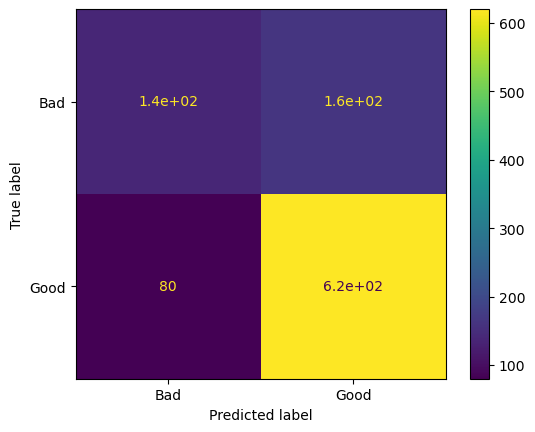

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Bad', 'Good'])
disp.plot()

plt.show()

The confusion matrix shows how many instances of each class were predicted correct and incorrect.

Considering a base scenario where the bank expected 100% of the customers they granted credits to would meet their debt obligations, this models is able to provide additional value already.

Approximately 140 cases were predicted correctly as defaulting on their credit, while misclassfing 80 cases as bad credits that actually are good credits.

So if the model was taken into production by the customer as is, it would provide around 140 correct classifications in 1000 cases of customers that wouldn't pay back their credit but were expected to do so by the bank. This comes at the cost of 80 wrong classifications in 1000 cases, that wouldn't be granted a credit according to this model eventough they would acutally meet their credit obligations. 

Furthermore, the rate of false postive classifaction needs to be reduced, as the model would predict around 160 instances as good credits that acutally are bad credits. This also comes at a cost for the customer.

In order to improve the predictive performance more features would help allow for more precise predictions. If possible we would incorporate features like the centralized credit history. Also geographic data would could add to the precision while allowing to identify possible regional patterns.

Along with the additional data, a more complex predictive model based on a neural network might also yield a higher accuracy. Once this is achievied we suggest designing a production model to analyse new customers applying for credits.

For the task of finding variables that influence if credit obligations would be meet, the explorative data analysis shows a slightly negative correlation between the credit duration the credit compliance. This means the chance of a credit default rises with the duration of the contract.

Therefore we advise to increase the scrutiny for customer who want a credit duration longer than 30 months or only provide these credits to customer that have the account status 4.